In [23]:
# Parameters
name = "2020-01-01-till-2021-02-28-tycho-brahe"
n_rows = None


# Explore how lat/long should be transformed into X/Y

# Purpose
* the problem needs to be transformed to carthesian coordinates: X,Y,(U,V).

# Methodology
* Transform lat/lon with the [pyproj](https://github.com/pyproj4/pyproj) package.
* $(\frac{dX}{dt})^2+(\frac{dY}{dt})^2=sog^2$ **?**


# Setup

In [24]:
# %load ../imports.py
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
width=20
height=3
plt.rcParams["figure.figsize"] = (width,height)
sns.set(rc={'figure.figsize':(width,height)})

#import seaborn as sns
import os
from collections import OrderedDict

from IPython.display import display

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)

import folium
import plotly.express as px
import plotly.graph_objects as go

import sys
import os

from sklearn.metrics import r2_score

import scipy.integrate
import seaborn as sns

import pyarrow as pa
import pyarrow.parquet as pq

import dask.dataframe
import statsmodels.api as sm

#sys.path.append('../')
from src.visualization import visualize
import scipy.integrate

try:
    import trip_statistics
except:
    import src.models.pipelines.longterm.scripts.prepdata.trip_statistics
    sys.path.insert(0, src.models.pipelines.longterm.scripts.prepdata.trip_statistics.path)
    import trip_statistics
    
try:
    import trip_id,prepare_dataset,trips
except:
    import src.models.pipelines.longterm.scripts.prepdata.trip
    sys.path.insert(0, src.models.pipelines.longterm.scripts.prepdata.trip.path)
    import trip_id,prepare_dataset,trips

try:
    import clean_statistics
except:
    import src.models.pipelines.longterm.scripts.prepdata.clean_statistics
    sys.path.insert(0, src.models.pipelines.longterm.scripts.prepdata.clean_statistics.path)
    import clean_statistics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
df_stat = clean_statistics.load_output_as_pandas_dataframe('pipelines/longterm/2020-01-01-till-2021-02-28-tycho-brahe/id_statistics_clean.parquet')
df_stat.head()

latitude  longitude     heading          P1          P2          P3  \
trip_no                                                                         
0.0      56.037954  12.657033   66.737998  414.949513  445.467671  360.205492   
1.0      56.034732  12.654767  259.289806  371.334951  398.771845  402.959547   
2.0      56.037121  12.657407   66.003030  384.353535  403.802571  356.265381   
3.0      56.035049  12.653717  260.582487  493.094571  522.021016  496.622592   
4.0      56.037667  12.658731   66.705934  408.187609  436.029668  358.720768   

                 P4            P         cog   sin_pm1   sin_pm2   sin_pm3  \
trip_no                                                                      
0.0      355.449956  1576.072631   72.063481 -0.018140  0.014034 -0.211319   
1.0      384.335761  1557.402104  254.945688  0.091474  0.168342  0.084861   
2.0      348.166208  1492.587695   72.778990  0.006538  0.041393 -0.123441   
3.0      468.592820  1980.330998  255.338827  0.021302  0.097969  0.098880   
4.0      348.050611  1550.988656   72.043185  0.009410  0.043116 -0.013878   

          sin_pm4   cos_pm1   cos_pm2   cos_pm3   cos_pm4  power_heeling  \
trip_no                                                                    
0.0     -0.166250 -0.672925 -0.675743 -0.809043 -0.803045       3.197520   
1.0      0.074851  0.777466  0.791547  0.676049  0.679201       0.851133   
2.0     -0.077197 -0.711043 -0.712979 -0.758449 -0.755415       2.035813   
3.0      0.087748  0.720291  0.731599  0.716466  0.718973       4.789842   
4.0      0.039514 -0.657692 -0.658992 -0.696761 -0.695680       5.315009   

              sog  trip_no  trip_time  reversing         trip_direction  \
trip_no                                                                   
0.0      4.410812      0.0     1136.0      False  Helsingør-Helsingborg   
1.0      4.057768      1.0     1250.0       True  Helsingborg-Helsingør   
2.0      4.428171      2.0     1089.0      False  Helsingør-Helsingborg   
3.0      4.354430      3.0     1143.0       True  Helsingborg-Helsingør   
4.0      4.270926      4.0     1145.0      False  Helsingør-Helsingborg   

                       start_time                  end_time             E1  \
trip_no                                                                      
0.0     2020-01-01 08:31:19+00:00 2020-01-01 08:50:15+00:00  469893.854167   
1.0     2020-01-01 09:02:02+00:00 2020-01-01 09:22:52+00:00  460129.833333   
2.0     2020-01-01 09:31:04+00:00 2020-01-01 09:49:13+00:00  418424.500000   
3.0     2020-01-01 10:01:22+00:00 2020-01-01 10:20:25+00:00  563269.250000   
4.0     2020-01-01 10:31:47+00:00 2020-01-01 10:50:52+00:00  467612.000000   

                    E2             E3             E4             E  \
trip_no                                                              
0.0      504329.645833  409072.500000  403732.625000  1.787029e+06   
1.0      494610.000000  499705.583333  476491.916667  1.930937e+06   
2.0      439643.416667  387886.250000  379041.666667  1.624996e+06   
3.0      596295.666667  567233.375000  535225.500000  2.262024e+06   
4.0      499508.916667  410869.416667  398641.000000  1.776631e+06   

            distance  
trip_no               
0.0      4981.662540  
1.0      5017.910403  
2.0      4822.139427  
3.0      4972.974752  
4.0      4894.255964

In [26]:
df_stat.describe()

latitude    longitude      heading           P1           P2  \
count  7789.000000  7789.000000  7789.000000  7789.000000  7789.000000   
mean     56.036773    12.655790   164.228172   403.938408   431.479100   
std       0.001302     0.002127    88.755432    83.558382    90.447894   
min      56.033056    12.649025    60.463121     0.000000     0.000000   
25%      56.035651    12.653883    76.998491   348.097009   369.547414   
50%      56.036963    12.656299    85.748354   403.206957   431.421517   
75%      56.037818    12.657521   252.530068   459.164026   492.265184   
max      56.041576    12.661998   269.260619   978.333333  1059.232356   

                P3           P4            P          cog      sin_pm1  \
count  7789.000000  7789.000000  7789.000000  7789.000000  7789.000000   
mean    378.582038   367.127274  1581.126820   163.283208    -0.037088   
std      93.435558    84.164894   311.763291    90.435971     0.077356   
min       0.000000     0.000000   740.128706    68.935299    -0.304549   
25%     317.567376   312.595008  1373.163793    73.560618    -0.082598   
50%     379.208443   368.291254  1581.783784    75.590123    -0.033184   
75%     441.264608   422.856719  1783.905109   254.567106     0.014181   
max     879.164640   835.109448  3486.773620   259.453081     0.207123   

           sin_pm2      sin_pm3      sin_pm4      cos_pm1      cos_pm2  \
count  7789.000000  7789.000000  7789.000000  7789.000000  7789.000000   
mean      0.013152    -0.014191     0.004287     0.029909     0.032527   
std       0.079593     0.097589     0.091358     0.723105     0.728462   
min      -0.250791    -0.328405    -0.322268    -0.997971    -0.999918   
25%      -0.038473    -0.084110    -0.057122    -0.683201    -0.686228   
50%       0.016515    -0.001631     0.009267    -0.591461    -0.593263   
75%       0.065184     0.051041     0.064829     0.760305     0.768435   
max       0.264698     0.329872     0.321608     0.960157     0.968933   

           cos_pm3      cos_pm4  power_heeling          sog      trip_no  \
count  7789.000000  7789.000000    7789.000000  7789.000000  7789.000000   
mean      0.005873     0.007779       1.961029     4.219653  4111.940172   
std       0.737844     0.739252       2.067475     0.261306  2380.942608   
min      -0.993153    -0.996954      -0.001550     3.437725     0.000000   
25%      -0.725518    -0.724364       0.465562     4.054896  2038.000000   
50%      -0.596112    -0.596629       1.465328     4.230684  4127.000000   
75%       0.747870     0.750643       2.866064     4.397100  6175.000000   
max       0.918569     0.993410      21.777959     5.364258  8214.000000   

         trip_time            E1            E2             E3             E4  \
count  7789.000000  7.789000e+03  7.789000e+03    7789.000000    7789.000000   
mean   1175.218000  4.703013e+05  5.022103e+05  441852.734995  428457.124360   
std      77.746784  8.295779e+04  8.936844e+04  103855.483381   92352.145501   
min     901.000000  0.000000e+00  0.000000e+00       0.000000       0.000000   
25%    1120.000000  4.164586e+05  4.419337e+05  374264.666667  369318.000000   
50%    1170.000000  4.667478e+05  4.995089e+05  435064.500000  424268.333333   
75%    1227.000000  5.216662e+05  5.587813e+05  507793.333333  485195.983333   
max    1412.000000  1.004576e+06  1.066812e+06  950916.083333  900434.166667   

                  E     distance  
count  7.789000e+03  7789.000000  
mean   1.842822e+06  4933.456478  
std    3.197397e+05   146.144770  
min    1.022875e+06  4598.500995  
25%    1.627580e+06  4833.296441  
50%    1.825067e+06  4872.508682  
75%    2.032271e+06  4982.512767  
max    3.735618e+06  5643.721180

In [27]:
df_stat.shape

(7789, 31)

In [28]:
df_stat.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 7789 entries, 0.0 to 8214.0
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   latitude        7789 non-null   float64            
 1   longitude       7789 non-null   float64            
 2   heading         7789 non-null   float64            
 3   P1              7789 non-null   float64            
 4   P2              7789 non-null   float64            
 5   P3              7789 non-null   float64            
 6   P4              7789 non-null   float64            
 7   P               7789 non-null   float64            
 8   cog             7789 non-null   float64            
 9   sin_pm1         7789 non-null   float64            
 10  sin_pm2         7789 non-null   float64            
 11  sin_pm3         7789 non-null   float64            
 12  sin_pm4         7789 non-null   float64            
 13  cos_pm1         7789 non-nu

In [29]:
df_stat.describe()

latitude    longitude      heading           P1           P2  \
count  7789.000000  7789.000000  7789.000000  7789.000000  7789.000000   
mean     56.036773    12.655790   164.228172   403.938408   431.479100   
std       0.001302     0.002127    88.755432    83.558382    90.447894   
min      56.033056    12.649025    60.463121     0.000000     0.000000   
25%      56.035651    12.653883    76.998491   348.097009   369.547414   
50%      56.036963    12.656299    85.748354   403.206957   431.421517   
75%      56.037818    12.657521   252.530068   459.164026   492.265184   
max      56.041576    12.661998   269.260619   978.333333  1059.232356   

                P3           P4            P          cog      sin_pm1  \
count  7789.000000  7789.000000  7789.000000  7789.000000  7789.000000   
mean    378.582038   367.127274  1581.126820   163.283208    -0.037088   
std      93.435558    84.164894   311.763291    90.435971     0.077356   
min       0.000000     0.000000   740.128706    68.935299    -0.304549   
25%     317.567376   312.595008  1373.163793    73.560618    -0.082598   
50%     379.208443   368.291254  1581.783784    75.590123    -0.033184   
75%     441.264608   422.856719  1783.905109   254.567106     0.014181   
max     879.164640   835.109448  3486.773620   259.453081     0.207123   

           sin_pm2      sin_pm3      sin_pm4      cos_pm1      cos_pm2  \
count  7789.000000  7789.000000  7789.000000  7789.000000  7789.000000   
mean      0.013152    -0.014191     0.004287     0.029909     0.032527   
std       0.079593     0.097589     0.091358     0.723105     0.728462   
min      -0.250791    -0.328405    -0.322268    -0.997971    -0.999918   
25%      -0.038473    -0.084110    -0.057122    -0.683201    -0.686228   
50%       0.016515    -0.001631     0.009267    -0.591461    -0.593263   
75%       0.065184     0.051041     0.064829     0.760305     0.768435   
max       0.264698     0.329872     0.321608     0.960157     0.968933   

           cos_pm3      cos_pm4  power_heeling          sog      trip_no  \
count  7789.000000  7789.000000    7789.000000  7789.000000  7789.000000   
mean      0.005873     0.007779       1.961029     4.219653  4111.940172   
std       0.737844     0.739252       2.067475     0.261306  2380.942608   
min      -0.993153    -0.996954      -0.001550     3.437725     0.000000   
25%      -0.725518    -0.724364       0.465562     4.054896  2038.000000   
50%      -0.596112    -0.596629       1.465328     4.230684  4127.000000   
75%       0.747870     0.750643       2.866064     4.397100  6175.000000   
max       0.918569     0.993410      21.777959     5.364258  8214.000000   

         trip_time            E1            E2             E3             E4  \
count  7789.000000  7.789000e+03  7.789000e+03    7789.000000    7789.000000   
mean   1175.218000  4.703013e+05  5.022103e+05  441852.734995  428457.124360   
std      77.746784  8.295779e+04  8.936844e+04  103855.483381   92352.145501   
min     901.000000  0.000000e+00  0.000000e+00       0.000000       0.000000   
25%    1120.000000  4.164586e+05  4.419337e+05  374264.666667  369318.000000   
50%    1170.000000  4.667478e+05  4.995089e+05  435064.500000  424268.333333   
75%    1227.000000  5.216662e+05  5.587813e+05  507793.333333  485195.983333   
max    1412.000000  1.004576e+06  1.066812e+06  950916.083333  900434.166667   

                  E     distance  
count  7.789000e+03  7789.000000  
mean   1.842822e+06  4933.456478  
std    3.197397e+05   146.144770  
min    1.022875e+06  4598.500995  
25%    1.627580e+06  4833.296441  
50%    1.825067e+06  4872.508682  
75%    2.032271e+06  4982.512767  
max    3.735618e+06  5643.721180

In [30]:
df_stat['trip_direction'].unique()

array(['Helsingør-Helsingborg', 'Helsingborg-Helsingør'], dtype=object)

Some data is missing, so that the trip_direction always has the sequence:0,1,0,... cannot be taken for granted:

## Time and direction matter

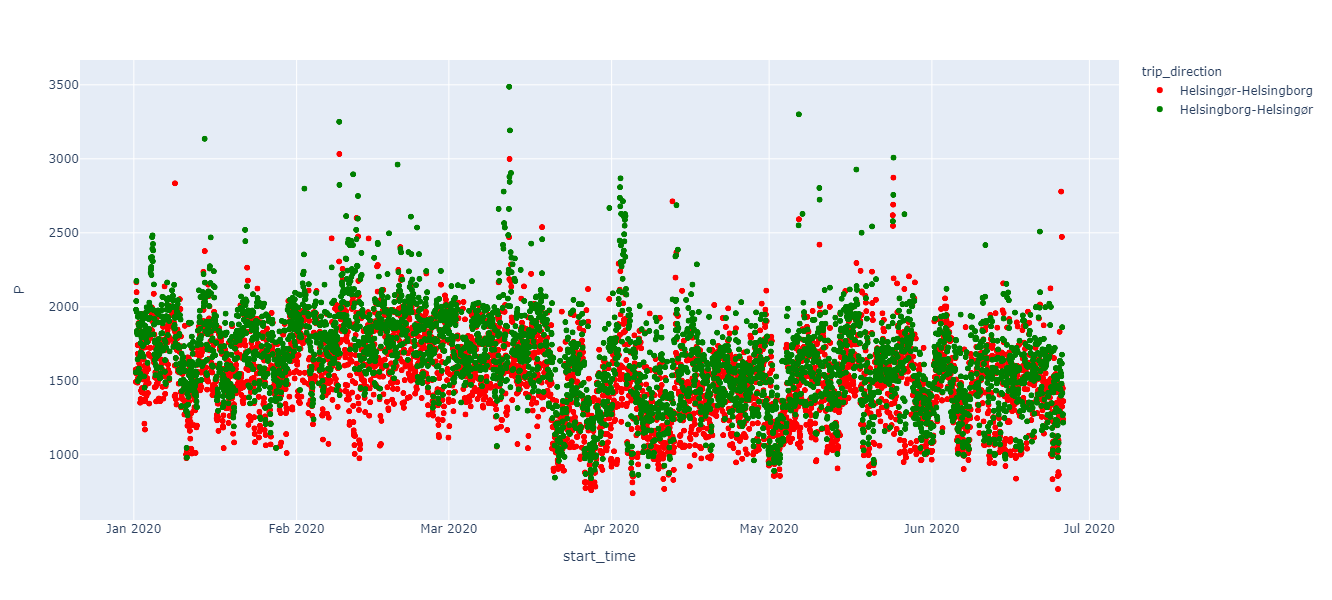

In [31]:
fig = px.scatter(df_stat, x='start_time',y='P', color='trip_direction', width=1500, height=600, 
                color_discrete_sequence=['red','green'], hover_data=['trip_no','trip_time','sog'])
fig.show()

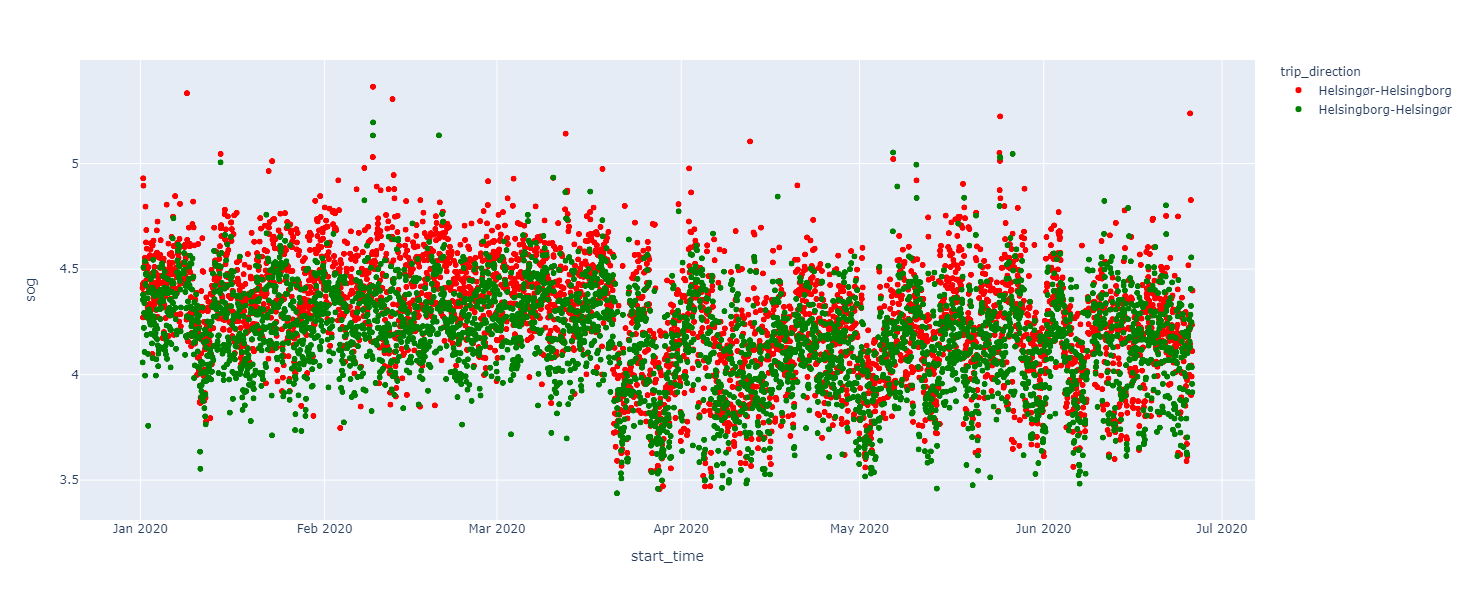

In [32]:
fig = px.scatter(df_stat, x='start_time',y='sog', color='trip_direction', width=1500, height=600, 
                color_discrete_sequence=['red','green'], hover_data=['trip_no','trip_time'])
fig.show()

In [33]:
trip_no = int(df_stat['latitude'].idxmax())

In [34]:
df_trips = trip_id.load_output_dask(path='pipelines/longterm/2020-01-01-till-2021-02-28-tycho-brahe/id.parquet')
df_trip = df_trips.groupby(by='trip_no').get_group(trip_no).compute()

In [35]:
visualize.plot_map(df_trip, time_step=None, color_key='trip_direction')

In [36]:
df_trip.head()

latitude  longitude  heading     P1     P2     P3  \
2020-01-04 16:03:06+00:00   56.0331   12.61721     77.1  231.0  228.0  200.0   
2020-01-04 16:03:07+00:00   56.0331   12.61721     77.1  266.0  260.0  224.0   
2020-01-04 16:03:08+00:00   56.0331   12.61722     77.0  304.0  297.0  252.0   
2020-01-04 16:03:09+00:00   56.0331   12.61722     76.9  346.0  339.0  286.0   
2020-01-04 16:03:10+00:00   56.0331   12.61723     76.8  380.0  388.0  324.0   

                              P4       P    cog  sin_pm1  sin_pm2  sin_pm3  \
2020-01-04 16:03:06+00:00  193.0   852.0  73.43 -0.05292 -0.00201  0.01553   
2020-01-04 16:03:07+00:00  216.0   966.0  73.31 -0.05093 -0.00055  0.01959   
2020-01-04 16:03:08+00:00  246.0  1099.0  73.34 -0.04688 -0.00052  0.02142   
2020-01-04 16:03:09+00:00  280.0  1251.0  73.26 -0.04388 -0.00064  0.02145   
2020-01-04 16:03:10+00:00  320.0  1412.0  73.29 -0.04379 -0.00058  0.02460   

                           sin_pm4  cos_pm1  cos_pm2  cos_pm3  cos_pm4  \
2020-01-04 16:03:06+00:00 -0.02686 -0.99631     -1.0     -1.0 -0.99988   
2020-01-04 16:03:07+00:00 -0.02686 -0.99646     -1.0     -1.0 -1.00000   
2020-01-04 16:03:08+00:00 -0.02695 -0.99643     -1.0     -1.0 -1.00000   
2020-01-04 16:03:09+00:00 -0.02707 -0.99637     -1.0     -1.0 -1.00000   
2020-01-04 16:03:10+00:00 -0.02695 -0.99643     -1.0     -1.0 -1.00000   

                           power_heeling       sog  trip_no  trip_time  \
2020-01-04 16:03:06+00:00            0.0  0.216067    157.0        0.0   
2020-01-04 16:03:07+00:00            0.0  0.257222    157.0        1.0   
2020-01-04 16:03:08+00:00            0.0  0.293233    157.0        2.0   
2020-01-04 16:03:09+00:00            0.0  0.324100    157.0        3.0   
2020-01-04 16:03:10+00:00            0.0  0.380689    157.0        4.0   

                           reversing  trip_direction  \
2020-01-04 16:03:06+00:00      False               0   
2020-01-04 16:03:07+00:00      False               0   
2020-01-04 16:03:08+00:00      False               0   
2020-01-04 16:03:09+00:00      False               0   
2020-01-04 16:03:10+00:00      False               0   

                                                time  
2020-01-04 16:03:06+00:00  2020-01-04 16:03:06+00:00  
2020-01-04 16:03:07+00:00  2020-01-04 16:03:07+00:00  
2020-01-04 16:03:08+00:00  2020-01-04 16:03:08+00:00  
2020-01-04 16:03:09+00:00  2020-01-04 16:03:09+00:00  
2020-01-04 16:03:10+00:00  2020-01-04 16:03:10+00:00

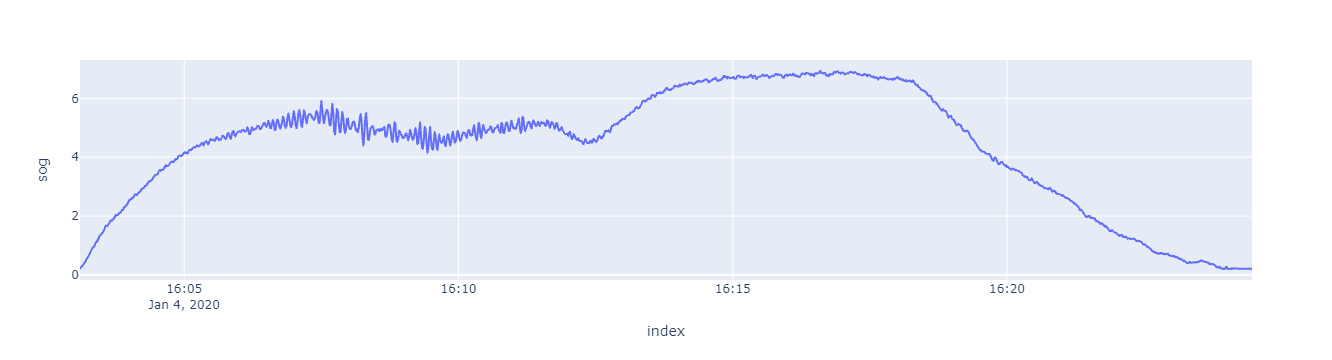

In [37]:
px.line(data_frame=df_trip, y='sog', width=1500, height=300,)

In [38]:
from pyproj import Proj
pp = Proj(proj='utm',zone=33,ellps='WGS84', preserve_units=False)

xx, yy = pp(df_trip["longitude"].values, df_trip["latitude"].values)
df_trip["X"] = xx - xx[0]
df_trip["Y"] = yy - yy[0] 

In [39]:
df_trip[['longitude','latitude','X','Y']].head()

longitude  latitude         X         Y
2020-01-04 16:03:06+00:00   12.61721   56.0331  0.000000  0.000000
2020-01-04 16:03:07+00:00   12.61721   56.0331  0.000000  0.000000
2020-01-04 16:03:08+00:00   12.61722   56.0331  0.622943 -0.021498
2020-01-04 16:03:09+00:00   12.61722   56.0331  0.622943 -0.021498
2020-01-04 16:03:10+00:00   12.61723   56.0331  1.245885 -0.042997

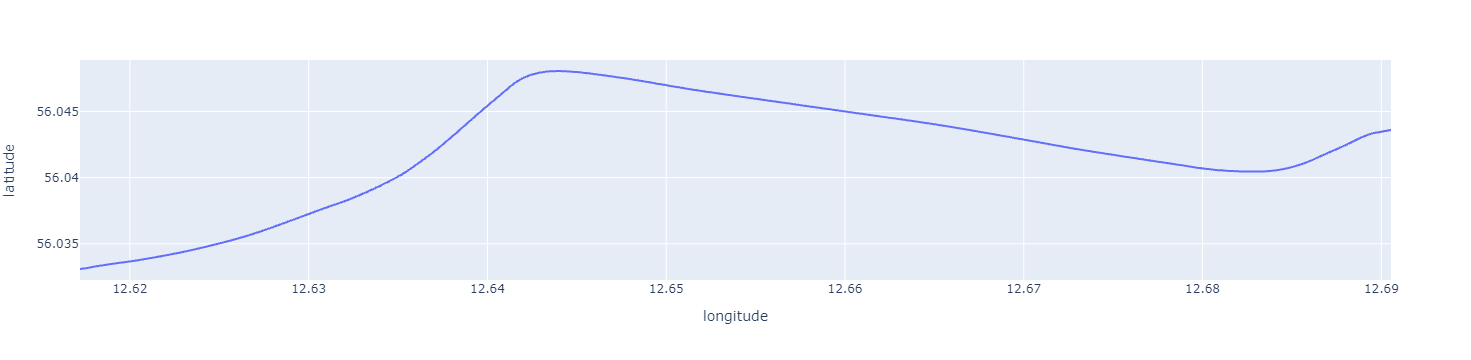

In [40]:
px.line(data_frame=df_trip, x='longitude', y='latitude', width=1500, height=300,)

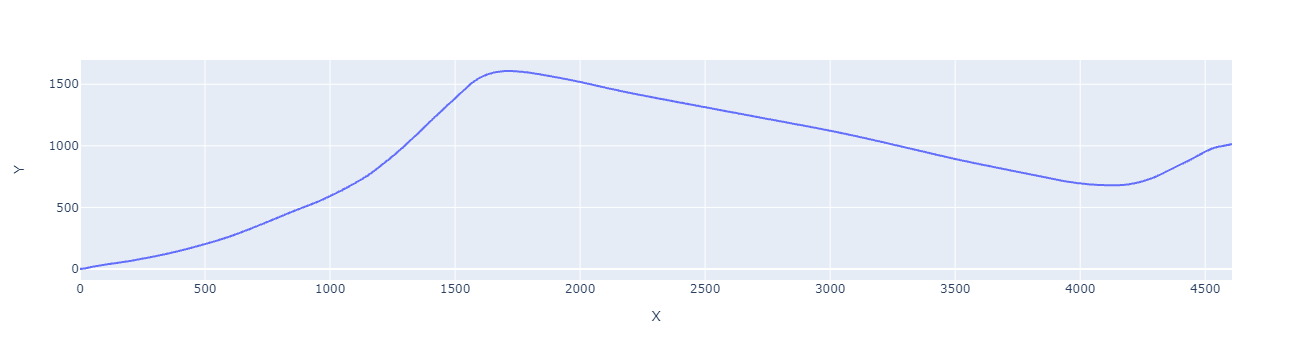

In [41]:
px.line(data_frame=df_trip, x='X', y='Y', width=1500, height=300,)

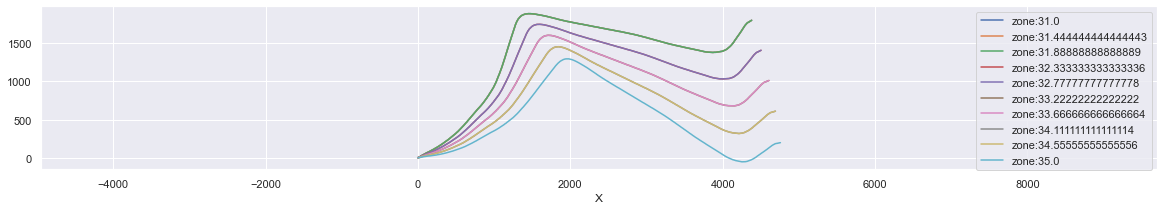

In [42]:
from pyproj import Proj


df_projections = pd.DataFrame()

for zone in np.linspace(31,35,10):
    pp = Proj(proj='utm',zone=zone,ellps='WGS84', preserve_units=False)
    xx, yy = pp(df_trip["longitude"].values, df_trip["latitude"].values)
    s = pd.DataFrame()
    s['X'] = xx - xx[0]
    s['Y'] = yy - yy[0]
    s['zone'] = zone
    df_projections = df_projections.append(s, ignore_index=True)

fig,ax=plt.subplots()    
for zone, s in df_projections.groupby(by='zone'):    
    s.plot(x='X', y='Y', label=f'zone:{zone}', ax=ax)
    
ax.axis('equal');
    

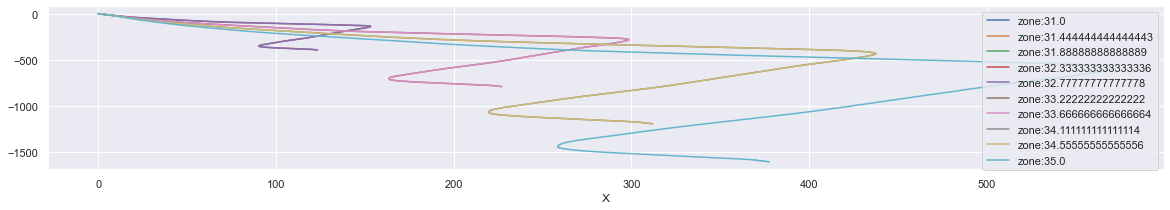

In [43]:
zones = df_projections.groupby(by='zone')
zone_0 = zones.get_group((list(zones.groups)[0]))

df_errors = pd.DataFrame()
df_errors['X'] = zones['X'].transform(lambda x : x-zone_0['X'].values)
df_errors['Y'] = zones['Y'].transform(lambda x : x-zone_0['Y'].values)
df_errors['zone'] = df_projections['zone']


fig,ax=plt.subplots()    
for zone, s in df_errors.groupby(by='zone'):    
    s.plot(x='X', y='Y', label=f'zone:{zone}', ax=ax)

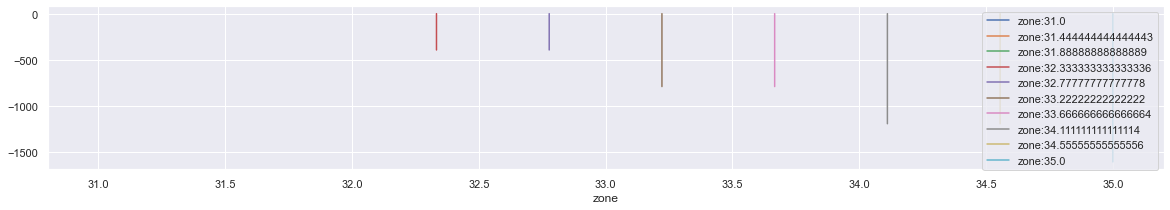

In [44]:
fig,ax=plt.subplots()    
for zone, s in df_errors.groupby(by='zone'):    
    s.plot(x='zone', y='Y', label=f'zone:{zone}', ax=ax)

## Check velocities
* $(\frac{dX}{dt})^2+(\frac{dY}{dt})^2=sog^2$ **?**

In [46]:
pp = Proj(proj='utm',zone=33,ellps='WGS84', preserve_units=False)

xx, yy = pp(df_trip["longitude"].values, df_trip["latitude"].values)
df_trip["X"] = xx - xx[0]
df_trip["Y"] = yy - yy[0] 

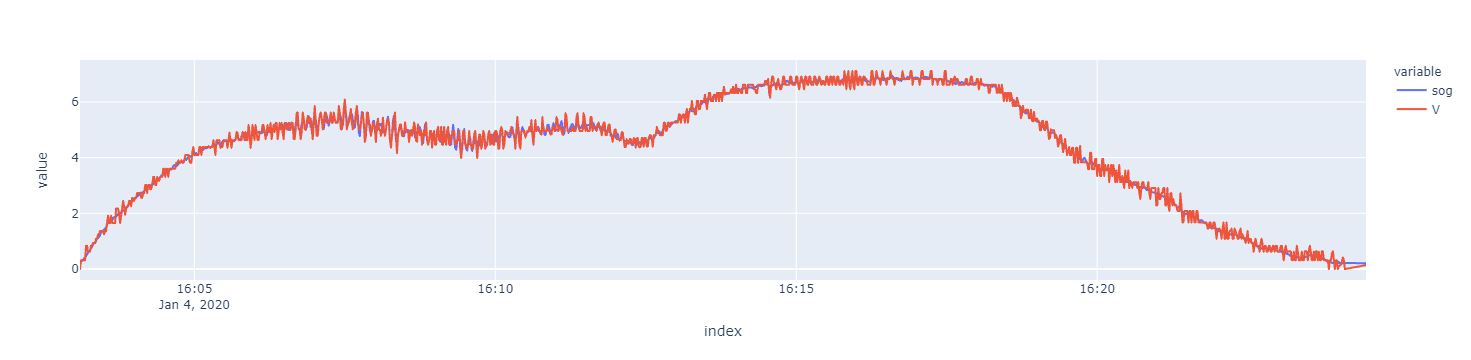

In [54]:
df_trip['Xd1'] = np.gradient(df_trip["X"],df_trip.trip_time)
df_trip['Yd1'] = np.gradient(df_trip["Y"],df_trip.trip_time)
df_trip['V'] = np.sqrt(df_trip['Xd1']**2 + df_trip['Yd1']**2)

px.line(data_frame=df_trip, y=['sog','V'], width=1400, height=300,)


In [56]:
df_trip[['sog','V']].mean()

sog    4.468447
V      4.477117
dtype: float64